In [28]:
! python --version

Python 3.7.6


In [29]:
from clusters import *
from os import listdir
from os.path import isfile, join
from operator import itemgetter
from networkx.algorithms import community #This part of networkx, for community detection, needs to be imported separately.

import cdlib
from cdlib.algorithms import louvain
from cdlib import evaluation

In [30]:
in_path = '../../stream_graph_data/networks_ground_truth_communities/'
network = 'email/email-Eu-core.txt'
membership = 'email/email-Eu-core-department-labels.txt'

### Build Graph

In [31]:
with open(in_path + network) as f:
    edges = f.readlines()
    edges = [tuple(line.strip().split(' ')) for line in edges]
    edges = [(int(x[0]), int(x[1])) for x in edges]
    
graph = nx.Graph()
graph.add_edges_from(edges)

print(nx.info(graph))
print("Network density:", nx.density(graph))

Name: 
Type: Graph
Number of nodes: 1005
Number of edges: 16706
Average degree:  33.2458
Network density: 0.03311331787278746


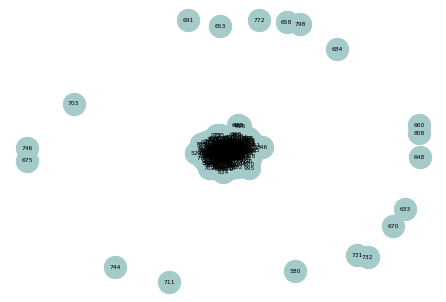

In [42]:
nx.draw(graph, with_labels=True, node_color='#A4CACA', figsize=(500,500), node_size=500, font_size=6)

In [ ]:
# If your graph has more than one component, this will return False:
print(nx.is_connected(graph))

# Next, use nx.connected_components to get the list of components,
# then use the max() command to find the largest one:
components = nx.connected_components(graph)
largest_component = max(components, key=len)

# Create a "subgraph" of just the largest component
# Then calculate the diameter of the subgraph, just like you did with density.
#

subgraph = graph.subgraph(largest_component)
diameter = nx.diameter(subgraph)
print("Network diameter of largest component:", diameter)

triadic_closure = nx.transitivity(graph)
print("Triadic closure:", triadic_closure)

## Centrality measures

In [ ]:
# degree: nodes with highest degree are hubs 
# calculate degree and add it as an attribute to the network
degree_dict = dict(graph.degree(graph.nodes()))
nx.set_node_attributes(graph, degree_dict, 'degree')

# sort dict by node degree
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)

print("Top 20 nodes by degree:")
for d in sorted_degree[:20]:
    print(d)

# eigenvector centrality: if a node is a hub, how many hubs is it connected to    
# useful for understanding which nodes can get information to many other nodes quickly. 
# If you know a lot of well-connected people, you could spread a message very efficiently.
eigenvector_dict = nx.eigenvector_centrality(graph) # Run eigenvector centrality

# betweenness centrality: looks at all the shortest paths that pass through a particular node
betweenness_dict = nx.betweenness_centrality(graph) # Run betweenness centrality

# assign each to an attribute in your network
nx.set_node_attributes(graph, betweenness_dict, 'betweenness')
nx.set_node_attributes(graph, eigenvector_dict, 'eigenvector')

# assign each to an attribute in the network
nx.set_node_attributes(graph, betweenness_dict, 'betweenness')
nx.set_node_attributes(graph, eigenvector_dict, 'eigenvector')

sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)
print(' ')
print("Top 20 nodes by betweenness centrality:")
for b in sorted_betweenness[:20]:
    print(b)
    
# which high-betweenness nodes are unexpected?

# first get the top 20 nodes by betweenness as a list
top_betweenness = sorted_betweenness[:20]

# then find and print their degree
print(' ')
for tb in top_betweenness: # Loop through top_betweenness
    degree = degree_dict[tb[0]] # Use degree_dict to access a node's degree, see footnote 2
    print("Name:", tb[0], "| Betweenness Centrality:", tb[1], "| Degree:", degree)

## Modularity

Modularity is a measure of relative density in your network: 
a community (called a module or modularity class) has high density relative to other nodes within its module 
but low density with those outside. 
Modularity gives you an overall score of how fractious a network is
and that score can be used to partition the network and return the individual communities.

In [101]:
communities_nx = community.greedy_modularity_communities(graph)
print('number of communities found ' + str(len(communities_nx)))

modularity_dict = {} # create a blank dictionary
for i,c in enumerate(communities_nx): # loop through the list of communities, keeping track of the number for the community
    for name in c: # loop through each person in a community
        modularity_dict[name] = i # create an entry in the dictionary for the person, where the value is which group they belong to.

# can add modularity information as attribute
nx.set_node_attributes(graph, modularity_dict, 'modularity')

# find and list all of the modularity classes and their members

for i,c in enumerate(communities_nx): # loop through the list of communities
#     if len(c) > 2: # filter out modularity classes with 2 or fewer nodes
      print('Class '+str(i)+':', list(c)) # Print out the classes and their members

number of communities found 44


## Ground truth membership

In [44]:
# NODEID DEPARTMENT

with open(in_path + membership) as file:
    m = file.readlines()
    m = [line.strip().split(' ') for line in m]
    m = [ [int(x[0]), int(x[1])] for x in m]
    
communities = [int(line[1]) for line in m]
communities = list(set(communities))

membership = defaultdict(list)

for item in m: 
    membership[item[1]].append(item[0])
    
communities = [int(line[1]) for line in m]
communities = list(set(communities))

# dictionary where values are communities (list of elements in a community)
membership = defaultdict(list)

for item in m: 
    membership[item[1]].append(item[0])

In [83]:
first_th = 0.08
second_th = 0.005

In [84]:
fps, fmap = findClusters(graph, first_th)
print('clusters found: ' + str(len(fmap)))
print('')

merged_fps, merged_fmap = mergeFingerprints(fps, fmap, second_th)
print('clusters merged: ' + str(len(fmap)-len(merged_fmap)))
print('remaining clusters: ' + str(len(merged_fmap)))

clusters found: 50

clusters merged: 8
remaining clusters: 42


In [85]:
# number of nodes from ground truth community in given cluster 
len([i for i in merged_fmap[0] if i in membership[1]])

25

## CDlib fitness 

In [90]:
# example
communities = louvain(graph)
mod = evaluation.newman_girvan_modularity(graph,communities)
mod.score

0.43215837750885905

In [88]:
# create NodeClustering object

clusters = list(merged_fmap.values())
method = 'Nidia'

# Parameters
# communities – list of communities
# graph – a networkx/igraph object
# method_name – community discovery algorithm name

c = cdlib.classes.node_clustering.NodeClustering(clusters, graph, method)
score = evaluation.newman_girvan_modularity(graph,c).score

In [89]:
score

0.3024323574455989

In [14]:
c = communities.communities
g = nx.karate_club_graph()

In [74]:
c

[[8, 14, 15, 18, 20, 22, 23, 26, 27, 29, 30, 32, 33],
 [0, 1, 2, 3, 7, 9, 11, 12, 13, 17, 19, 21],
 [4, 5, 6, 10, 16],
 [24, 25, 28, 31]]

In [19]:
# Parameters
# communities – list of communities
# graph – a networkx/igraph object
# method_name – community discovery algorithm name
# method_parameters – configuration for the community discovery algorithm used
# overlap – boolean, whether the partition is overlapping or not

x = cdlib.classes.node_clustering.NodeClustering(c,g,'Nidia')

In [25]:
evaluation.newman_girvan_modularity(g,x).score

0.4155982905982906